In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
# Load dataset
df = pd.read_csv("../data/SuperstoreData.csv", encoding='latin1')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [71]:
# View column names
df.columns.tolist()

# Check for missing values
df.isnull().sum()

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [72]:
# Fix data types (Order Date & Ship Date)
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y', errors='coerce')
df['Order Date']  
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%m/%d/%Y', errors='coerce')
df['Ship Date']

0      2016-11-11
1      2016-11-11
2      2016-06-16
3      2015-10-18
4      2015-10-18
          ...    
9989   2014-01-23
9990   2017-03-03
9991   2017-03-03
9992   2017-03-03
9993   2017-05-09
Name: Ship Date, Length: 9994, dtype: datetime64[ns]

In [73]:
# Summary statistics for numeric columns
print("\nSummary statistics:\n", df.describe())


Summary statistics:
             Row ID                     Order Date  \
count  9994.000000                           9994   
mean   4997.500000  2016-04-30 00:07:12.259355648   
min       1.000000            2014-01-03 00:00:00   
25%    2499.250000            2015-05-23 00:00:00   
50%    4997.500000            2016-06-26 00:00:00   
75%    7495.750000            2017-05-14 00:00:00   
max    9994.000000            2017-12-30 00:00:00   
std    2885.163629                            NaN   

                           Ship Date   Postal Code         Sales     Quantity  \
count                           9994   9994.000000   9994.000000  9994.000000   
mean   2016-05-03 23:06:58.571142912  55190.379428    229.858001     3.789574   
min              2014-01-07 00:00:00   1040.000000      0.444000     1.000000   
25%              2015-05-27 00:00:00  23223.000000     17.280000     2.000000   
50%              2016-06-29 00:00:00  56430.500000     54.490000     3.000000   
75%           

In [74]:
# Check for negative profits
neg_profits = df[df['Profit'] < 0]
neg_profits.shape[0]

1871

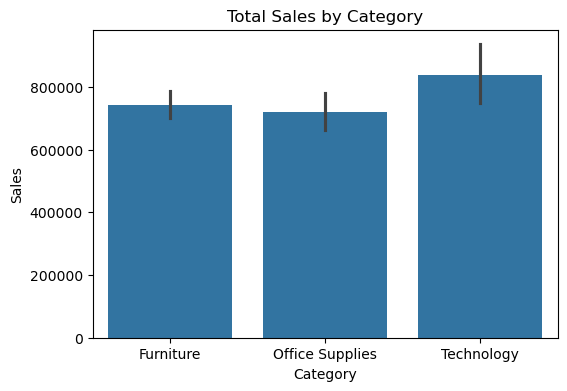

In [75]:
# Quick visualization – Sales by Category
plt.figure(figsize=(6,4))
sns.barplot(x='Category', y='Sales', data=df, estimator=sum)
plt.title('Total Sales by Category')
plt.show()

Deeper EDA
#Check sales trends over time (monthly/yearly)
#Identify top customers/products
#Look at profit vs discountS
#Region-wise and segment-wise performance
#Spot loss-making areas (negative profit)